In [15]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import kagglehub

**Dataset Download and Setup**

In this step, we use the kagglehub library to automatically download the brain tumor segmentation dataset from Kaggle. Once downloaded, we set up the paths to the folders containing the MRI images (images/) and their corresponding tumor masks (masks/). We also define key parameters for processing the data, including resizing all images and masks to 128x128 pixels and specifying that the images are grayscale (single channel). This setup ensures the data is organized and ready for preprocessing and model training.

In [16]:
# Download the dataset using kagglehub
dataset_path = kagglehub.dataset_download('nikhilroxtomar/brain-tumor-segmentation')

# Set image and mask directories
IMAGE_DIR = os.path.join(dataset_path, 'images/')
MASK_DIR = os.path.join(dataset_path, 'masks/')

# Parameters
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 1  # Grayscale

**Data Loading and Preprocessing**

This code loads the brain MRI images and tumor masks, resizes them to 128×128 pixels, normalizes pixel values to between 0 and 1, and reshapes them to include a channel dimension. It then converts everything into arrays ready for model training, and prints the dataset size for verification.

In [17]:
# Load and preprocess images and masks
def load_data(image_dir, mask_dir):
    images = []
    masks = []
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))
    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Read in grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Resize
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))

        # Normalize
        img = img / 255.0
        mask = mask / 255.0

        # Expand dims for channel
        img = np.expand_dims(img, axis=-1)
        mask = np.expand_dims(mask, axis=-1)

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Load the data
X, Y = load_data(IMAGE_DIR, MASK_DIR)

# Print dataset shape
print("Images shape:", X.shape)
print("Masks shape:", Y.shape)

Images shape: (3064, 128, 128, 1)
Masks shape: (3064, 128, 128, 1)


**Visualizing a Sample Image and Mask**

This function displays a side-by-side comparison of a brain MRI image and its corresponding tumor mask from the dataset. It helps visually verify that the images and masks are properly loaded and preprocessed before training the model. The sample shown is the first pair in the dataset.

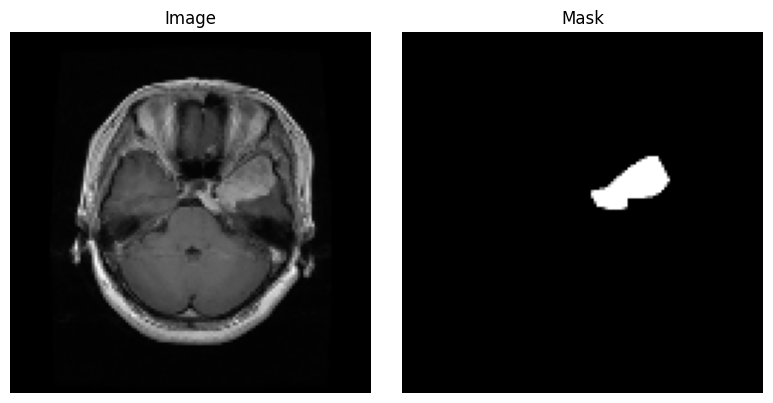

In [18]:
# Show a sample image and mask
def show_sample(index=0):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(X[index].squeeze(), cmap='gray')
    ax[0].set_title('Image')
    ax[1].imshow(Y[index].squeeze(), cmap='gray')
    ax[1].set_title('Mask')
    for a in ax: a.axis('off')
    plt.tight_layout()
    plt.show()

# Show first sample
show_sample(0)

**Data Splitting and U-Net Model Definition**

**First**, the dataset is split into training and validation sets, with 10% of the data reserved for validation to evaluate the model's performance during training.

**Next**, a U-Net architecture is defined—a popular convolutional neural network designed for image segmentation tasks. The model consists of:

**Encoder** (contracting path): progressively extracts features through convolutional layers and downsamples the spatial dimensions using max pooling.

**Bottleneck**: captures the most abstract features at the lowest spatial resolution.

**Decoder**(expanding path): upsamples the features back to the original image size using transpose convolutions, concatenating corresponding encoder feature maps via skip connections to preserve spatial details.

**Output layer**: uses a sigmoid activation to generate a pixel-wise probability map indicating the presence of tumor regions.

This U-Net model is well-suited for segmenting brain tumors from MRI images.

In [12]:
# Split data
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

# Define U-Net model
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

**Model Compilation, Training, and Evaluation**

The U-Net model is compiled using the Adam optimizer and binary cross-entropy loss, suitable for the binary segmentation task. The model is then trained on the training set for 20 epochs with a batch size of 16, while monitoring its performance on the validation set.

After training, the model is evaluated on the validation data to report the final loss and accuracy, providing insight into how well the model segments brain tumors on unseen data.

In [13]:
# Compile model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=16, epochs=20)

# Evaluate model
loss, accuracy = model.evaluate(X_val, Y_val)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 1))
  warnings.warn(msg)


173/173 ━━━━━━━━━━━━━━━━━━━━ 108s 437ms/step - accuracy: 0.9513 - loss: 0.5090 - val_accuracy: 0.9824 - val_loss: 0.0623
Epoch 2/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 81s 235ms/step - accuracy: 0.9824 - loss: 0.0609 - val_accuracy: 0.9824 - val_loss: 0.0613
Epoch 3/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 41s 236ms/step - accuracy: 0.9827 - loss: 0.0599 - val_accuracy: 0.9824 - val_loss: 0.0537
Epoch 4/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 40s 232ms/step - accuracy: 0.9832 - loss: 0.0505 - val_accuracy: 0.9852 - val_loss: 0.0409
Epoch 5/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 41s 232ms/step - accuracy: 0.9846 - loss: 0.0444 - val_accuracy: 0.9844 - val_loss: 0.0430
Epoch 6/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 42s 238ms/step - accuracy: 0.9862 - loss: 0.0376 - val_accuracy: 0.9874 - val_loss: 0.0357
Epoch 7/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 40s 232ms/step - accuracy: 0.9878 - loss: 0.0331 - val_accuracy: 0.9887 - val_loss: 0.0303
Epoch 8/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 41s 238ms/step - accuracy: 0.9879 - loss: 0.0315 - va

**Predicting and Visualizing Segmentation Results**

This function generates predictions for a few samples from the validation set and visualizes the results side-by-side. For each sample, it shows:

The original brain MRI image,

The ground truth tumor mask,

The tumor mask predicted by the trained U-Net model.

This visual comparison helps to qualitatively assess how well the model segments the tumors compared to the actual annotations

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(5, 128, 128, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


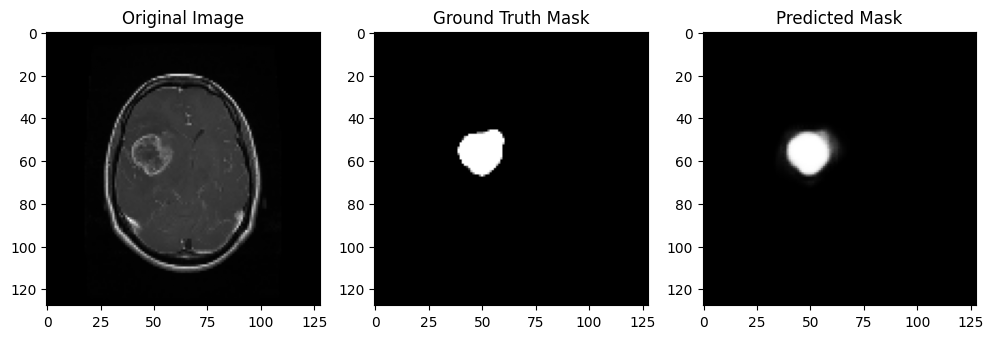

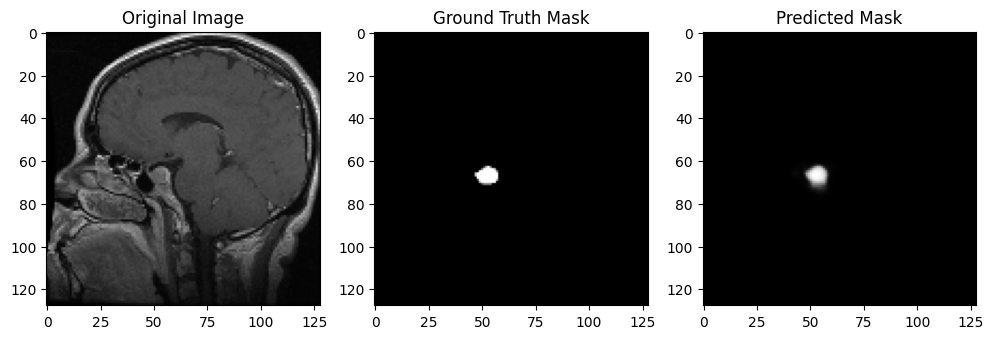

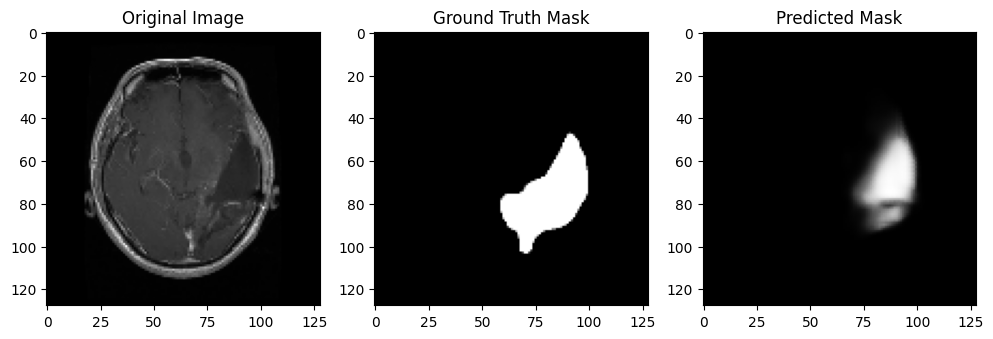

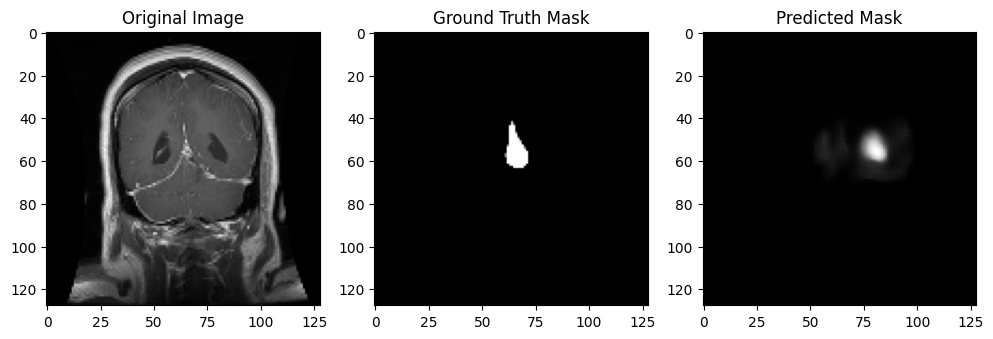

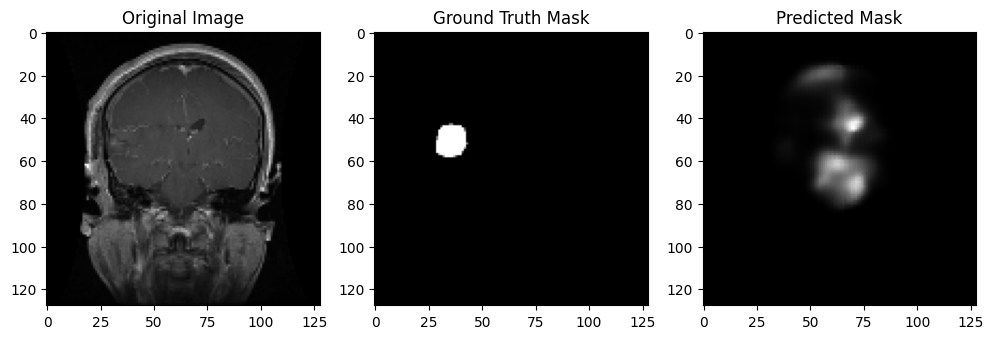

In [14]:
# Predict and visualize results
def visualize_predictions(model, X, Y, num=5):
    preds = model.predict(X[:num])
    for i in range(num):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(X[i].squeeze(), cmap='gray')
        plt.title('Original Image')

        plt.subplot(1, 3, 2)
        plt.imshow(Y[i].squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')

        plt.subplot(1, 3, 3)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')

        plt.show()

# Visualize predictions
visualize_predictions(model, X_val, Y_val)